## Mutual information estimator implementation for the mixed discrete-continuous random variables case

see [Mutual Information between Discrete and Continuous Data Sets. Brian C. Ross](http://journals.plos.org/plosone/article?id=10.1371%2Fjournal.pone.0087357)

In [1]:
import numpy as np
from scipy.special import digamma

EPS = np.finfo(float).eps

# @TODO change the implementation to a more efficient one:
# split the original c by the corresponding d value and use scipy.spatial.cKDTree
# for each sub array to efficiently compute distances
def mutual_information_mixed(d, c, k=3):
    assert(len(c) == len(d))

    indexes = np.argsort(c)
    c = c[indexes]
    d = d[indexes]

    def compute_k_distance(index):
        dval = d[index]        
    
        def _compute_k_distance(l,r,i):
            if (i == k):
                return max(c[r] - c[index], c[index] - c[l])
            
            r_new = r + 1
            while (r_new < len(c)):
                if (d[r_new] == dval): break
                r_new += 1
        
            l_new = l - 1
            while (-1 < l_new): 
                if (d[l_new] == dval): break
                l_new -= 1
            
            if (-1 < l_new and r_new < len(c)):
                if c[index] - c[l_new] < c[r_new] - c[index]:
                    l = l_new
                else:
                    r = r_new
                return _compute_k_distance(l, r, i + 1)
            elif (-1 < l_new):
                return _compute_k_distance(l_new, r, i + 1)
            elif (r_new < len(c)):
                return _compute_k_distance(l, r_new, i + 1)
            else:
                return max(c[-1] - c[index], c[index] - c[0])
          
        return _compute_k_distance(index, index, 0)


    def compute_M_i(index):
        distance = compute_k_distance(index)
        
        l = index - 1
        while (0 <= l):
            if distance + EPS < c[index] - c[l]:
                break
            l -= 1
        l += 1
        
        r = index + 1
        while (r < len(c)):
            if distance + EPS < c[r] - c[index]:
                break
            r += 1
        r -= 1
    
        return r - l # the element itself doesn't count
    
    m = np.empty(len(c))
    N_ds = dict()
    
    #loop over all elements computing M_i's and N_x's
    for i, dval in enumerate(d):
        m[i] = compute_M_i(i)
        N_ds.setdefault(dval, 0)
        N_ds[dval] += 1
   
    result = digamma(len(c)) - sum([n/len(c) * digamma(n) for n in N_ds.values()]) + digamma(k) - np.mean(digamma(m))
    return result / np.log(2)

In [2]:
#testing

N = 10000
pdf_params = [(-0.4, 0.2), (0.5, 0.3), (0.8, 0.25)]
p_x = np.array([0.3, 0.5, 0.2])

def generate_data(mu, sigma, n):
    return mu + sigma * np.random.randn(n)

ys = [generate_data(mu, sigma, int(N*px)) for px, (mu, sigma) in zip(p_x, pdf_params)]

In [3]:
import scipy.integrate as integrate

def mutual_info_mixed(p_x, p_yIx):
    
    def p_y(y):
        return sum([px*pyIx(y) for px, pyIx in zip(p_x, p_yIx)])
    
    def make_integratum(pyIx):
        def integratum(y):
            return pyIx(y) * np.log2(pyIx(y)/p_y(y))
        return integratum
    
    return sum(px*integrate.quad(make_integratum(pyIx), mu - 10*sigma, mu + 10*sigma)[0] for px, pyIx, (mu, sigma) in zip(p_x, p_yIx, pdf_params))

In [4]:
#test data for analytical case
import matplotlib.mlab as mlab

def make_pdfs(mu, sigma):
    def pdf(x):
        return mlab.normpdf(x, mu, sigma)
    return pdf

y_pdfs = [make_pdfs(mu, sigma) for mu, sigma in pdf_params]

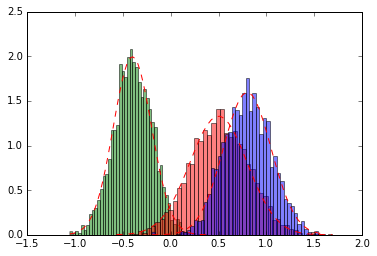

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

num_bins = 50

for y_i, pdf, color in zip(ys, y_pdfs, ['green', 'red', 'blue']):
    _, bins, _ = plt.hist(y_i, num_bins, normed=1, facecolor=color, alpha=0.5)
    plt.plot(bins, pdf(bins), 'r--')

# add plots for analytically defined functions
    
plt.show()

In [6]:
y = np.hstack(ys)
print(len(y))
x = np.hstack(n*np.ones(len(x_i)) for x_i, n in zip(ys, range(len(p_x))))
print(len(x), np.unique(x), np.mean(x))

10000
10000 [ 0.  1.  2.] 0.9


In [7]:
mutual_information_mixed(x,y)

0.88433101297668637

In [8]:
mutual_info_mixed(p_x, y_pdfs)

0.8794982724139484

[NPEET](https://github.com/gregversteeg/NPEET) needs to be manually installed

*note: for Python 3 in order to work script needs to be fixed on line 29: wrap the map call into a list constructor*

In [9]:
import entropy_estimators as ee

ee.entropy([[y_i] for y_i in y])

0.98140174624868382

In [10]:
ee.entropyd(x)

1.4854752972273346

In [11]:
def uncertainty_coefficient(d, c):
    return mutual_information_mixed(d, c) / ee.entropyd(d)

In [12]:
uncertainty_coefficient(x,y)

0.59531855873154238

NPEET mixed mutual infromation implementation gives not such bad results

In [13]:
micd([[y_i] for y_i in y], x)

0.88629050754652916